# <center>Data 1030 - Final Project</center>

### Data 1030 Environment

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.9":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.9":
    print(FAIL, "Python version 3.9 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.21.1", 'matplotlib': "3.4.2",'sklearn': "0.24.2", 
                'pandas': "1.3.1",'xgboost': "1.3.3", 'shap': "0.39.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.9.7 | packaged by conda-forge | (default, Sep  2 2021, 17:58:46) 
[Clang 11.1.0 ]

[ OK ] numpy version 1.21.1 is installed.
[ OK ] matplotlib version 3.4.2 is installed.
[ OK ] sklearn version 0.24.2 is installed.
[ OK ] pandas version 1.3.1 is installed.
[ OK ] xgboost version 1.3.3 is installed.
[ OK ] shap version 0.39.0 is installed.


### Exploratory Data Analysis
Read the white wine quality dataset into a pandas data frame.

In [2]:
import pandas as pd

# load data from a csv file
df = pd.read_csv('../data/winequality-white.csv', sep=';')

print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

The number of rows and columns:

In [3]:
print('The number of rows:', df.shape[0])
print('The number of columns:', df.shape[1])

The number of rows: 4898
The number of columns: 12


The data types of the columns. Based on the data description, the quality column is categorical and all features are continuous.

In [4]:
print(df.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


The target variable is `quality`, which is a categorical column.

### Data Preprocessing
Split the dataset, and use the standard scaler to the continuous features.

**The original y**

In [5]:
# separate the feature matrix X, and target variable y
y = df['quality'] #We want to do the classification for predicting the quality of white wine
X = df.loc[:, df.columns != 'quality'] # all other columns are features
print(X.head())
print(y)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  
0      8.8  
1      9.5  
2     10.1  
3      9.9  
4      9.9  
0       

**Transform y into 3 categories**

3-4: Low, 5-6: Medium, 7-9: High

In [6]:
pd.options.mode.chained_assignment = None
y[(y >=3) & (y <= 4)] = 0
y[(y >=5) & (y <= 6)] = 1
y[(y >= 7)] = 2

In [7]:
# stratified K Fold: The features in the dataset are generally IID, and the quality column is imbalanced. 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

random_state = 42

# stratified train-test split
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=random_state)
print('test balance:',y_test.value_counts(normalize=True)) #20% of points are in the test set

# do StratifiedKFold split on other
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    
    #use StandardScaler to the data
    scaler = StandardScaler()
    X_train_prep = scaler.fit_transform(X_train)
    X_val_prep = scaler.transform(X_val)
    X_test_prep = scaler.transform(X_test)
    
    print('train balance:')
    print(y_train.value_counts(normalize=True))
    print('training set:', X_train_prep.shape)
    print(X_train_prep)
    print('val balance:')
    print(y_val.value_counts(normalize=True))
    print('validation set:', X_val_prep.shape)
    print(X_val_prep)
    print('test set:', X_test_prep.shape) 
    print(X_test_prep)
    
#Check Reproducibility: We run the code several times, each time the output is the same.

test balance: 1    0.745918
2    0.216327
0    0.037755
Name: quality, dtype: float64
train balance:
1    0.746172
2    0.216309
0    0.037519
Name: quality, dtype: float64
training set: (2612, 11)
[[ 1.97927818 -0.86258508  1.94690873 ... -0.78928815  1.58277765
  -1.00867989]
 [ 1.3786119   0.61664998  1.34606006 ... -0.39679786 -0.94451511
   1.45191323]
 [-0.66365345  0.2221873   4.95115206 ...  1.30399337  0.01411318
   0.9597946 ]
 ...
 [ 1.13834539 -0.76396941 -1.14317012 ... -1.05094834 -0.2473309
   0.9597946 ]
 [ 0.17727934  0.61664998  0.48770483 ... -0.52762796  0.36270528
  -0.84464035]
 [-0.06298717  2.8848104  -0.37065041 ...  0.84608804  2.19281384
  -0.27050196]]
val balance:
1    0.746554
2    0.216692
0    0.036753
Name: quality, dtype: float64
validation set: (1306, 11)
[[-0.66365345  0.12357163  0.57354035 ... -0.26596777 -0.42162696
  -1.00867989]
 [ 1.49874516  0.32080297  0.23019826 ... -1.18177843 -1.29310722
   2.02605162]
 [-1.02405322 -0.07365971 -0.28481489

We choose to use a basic split and stratified K fold split, and for reusing the data, we save the preprocessed other sets and test sets into a file.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

test_sets = []
other_sets = []

for i in range(10):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42*i)
    
    #use StandardScaler to the data
    scaler = StandardScaler()
    X_other_prep = scaler.fit_transform(X_other)
    X_test_prep = scaler.transform(X_test)
    
    test_sets.append((X_test_prep, y_test))
    other_sets.append((X_other_prep, y_other))

In [9]:
import pickle
file = open('../data/data_preprocessed.save', 'wb')
pickle.dump((other_sets, test_sets),file)
file.close()

## Train models and Tune parameters

Create a function to try different models.

In [10]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score

def MLpipe_KFold(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 3 folds to other.
    '''
    #we will loop through nr_states random states
    nr_states = 10
    accuracy = np.zeros(nr_states)
    recall = np.zeros(nr_states)
    precision = np.zeros(nr_states)
    f1 = np.zeros(nr_states)
    best_models = []
    final_models = []
    for i in range(nr_states):
        # first split to separate out the test set
        # we will use kfold on other
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)

        # splitter for other
        kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42*i)
        # the initialized classifier is ML_algo

        # let's put together a pipeline
        # the pipeline will fit_transform the training set (2 folds), and transform the last fold used as validation
        # then it will train the ML algorithm on the training set and evaluate it on the validation set
        # it repeats this step automatically such that each fold will be an evaluation set once
        pipe = make_pipeline(preprocessor, ML_algo)

        # use GridSearchCV
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                            cv=kf, return_train_score = True, n_jobs=-1, verbose=True)

        # this line actually fits the model on other
        grid.fit(X_other, y_other)
        best_models.append(grid.best_estimator_)
 
        # save the model
        final_models.append(grid)
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test)
        accuracy[i] = accuracy_score(y_test, y_test_pred)
        precision[i] = precision_score(y_test, y_test_pred, average='micro')
        recall[i] = recall_score(y_test, y_test_pred, average='micro')
        f1[i] = fbeta_score(y_test, y_test_pred, beta=1, average='micro')
    
    return best_models, accuracy, precision, recall, f1

Initiate preprocessor

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# separate the feature matrix X, and target variable y
std_ftrs = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
import numpy as np

log_param = {'logisticregression__penalty': ['l1', 'l2'],
             'logisticregression__C': np.logspace(-4,4,9)}

# initialize a simple logistic regression model
# only 'saga' solver can support these 4 kinds of penalty
LogReg = LogisticRegression(random_state=42, max_iter=100000000, solver='saga') 
best_models_log, accuracy_log, precision_log, recall_log, f1_log = MLpipe_KFold(X, y, preprocessor, LogReg, log_param)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [13]:
print('best models:', best_models_log)
print('accuracy scores:', accuracy_log)
print('precision scores:', precision_log)
print('recall scores:', recall_log)
print('f1 scores:', f1_log)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=100000000, random_state=42,
                                    solver='saga'))]), Pipeline(steps=[('columntransformer',
                 ColumnTr

In [14]:
print('mean accuracy score: ', np.mean(accuracy_log))
print('std accuracy score: ', np.std(accuracy_log))

mean accuracy score:  0.7648979591836734
std accuracy score:  0.0168549684815967


In [15]:
import pickle
file = open('../results/log_models.save', 'wb')
pickle.dump(best_models_log, file)
file.close()

### ElasticNet

In [16]:
log_base = {'logisticregression__penalty': ['elasticnet'],
            'logisticregression__C': np.logspace(-4,4,9), 
            'logisticregression__l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99],
            'logisticregression__solver': ['saga']}
logreg_base = LogisticRegression(random_state=42, max_iter=100000000, solver='saga')
best_models_elastic, accuracy_elastic, precision_elastic, recall_elastic, f1_elastic = MLpipe_KFold(X, y, preprocessor, logreg_base, log_base)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits
Fitting 3 folds for each of 63 candidates, totalling 189 fits


In [17]:
print('best models:', best_models_elastic)
print('accuracy scores:', accuracy_elastic)
print('precision scores:', precision_elastic)
print('recall scores:', recall_elastic)
print('f1 scores:', f1_elastic)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, l1_ratio=0.01, max_iter=100000000,
                                    penalty='elasticnet', random_state=42,
                                    solver='s

In [18]:
print('mean accuracy score: ', np.mean(accuracy_elastic))
print('std accuracy score: ', np.std(accuracy_elastic))

mean accuracy score:  0.7646938775510204
std accuracy score:  0.01674340241303564


In [19]:
import pickle
file = open('../results/elastic_models.save', 'wb')
pickle.dump(best_models_elastic, file)
file.close()

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc_param = {'randomforestclassifier__max_depth': [1, 3, 5, 10, 20, 100, 300], 
             'randomforestclassifier__n_estimators': [1, 3, 10, 100],
             'randomforestclassifier__min_samples_split': [8, 16, 32, 64, 128]}

rfc = RandomForestClassifier(random_state=3)
best_models_rf, accuracy_rf, precision_rf, recall_rf, f1_rf = MLpipe_KFold(X, y, preprocessor, rfc, rfc_param)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits
Fitting 3 folds for each of 140 candidates, totalling 420 fits


In [21]:
print('best models:', best_models_rf)
print('accuracy scores:', accuracy_rf)
print('precision scores:', precision_rf)
print('recall scores:', recall_rf)
print('f1 scores:', f1_rf)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, min_samples_split=8,
                                        random_state=3))]), Pipeline(steps=[('columntransformer',
                 Colu

In [22]:
print('mean accuracy score: ', np.mean(accuracy_rf))
print('std accuracy score: ', np.std(accuracy_rf))

mean accuracy score:  0.8365306122448981
std accuracy score:  0.018292363951262502


In [23]:
import pickle
file = open('../results/rf_models.save', 'wb')
pickle.dump(best_models_rf, file)
file.close()

### SVC

In [24]:
from sklearn.svm import SVC
SVC_param = {'svc__C': [0.01, 0.1, 1, 10, 100], 
             'svc__gamma': [0.01, 0.1, 1, 10, 100]}

SVC_ml = SVC(random_state=42)
best_models_svc, accuracy_svc, precision_svc, recall_svc, f1_svc = MLpipe_KFold(X, y, preprocessor, SVC_ml, SVC_param)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [25]:
print('best models:', best_models_svc)
print('accuracy scores:', accuracy_svc)
print('precision scores:', precision_svc)
print('recall scores:', recall_svc)
print('f1 scores:', f1_svc)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('svc', SVC(C=10, gamma=1, random_state=42))]), Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed aci

In [26]:
print('mean accuracy score: ', np.mean(accuracy_svc))
print('std accuracy score: ', np.std(accuracy_svc))

mean accuracy score:  0.831734693877551
std accuracy score:  0.016532186873857716


In [27]:
import pickle
file = open('../results/svc_models.save', 'wb')
pickle.dump(best_models_svc, file)
file.close()

### KNC

In [28]:
from sklearn.neighbors import KNeighborsClassifier
knc_param = {'kneighborsclassifier__n_neighbors': [1, 3, 5, 11, 50, 100, 200], 
             'kneighborsclassifier__weights': ['uniform', 'distance'], 
             'kneighborsclassifier__metric': ['euclidean', 'manhattan']}

knc = KNeighborsClassifier()
best_models_knn, accuracy_knn, precision_knn, recall_knn, f1_knn = MLpipe_KFold(X, y, preprocessor, knc, knc_param)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [29]:
print('best models:', best_models_knn)
print('accuracy scores:', accuracy_knn)
print('precision scores:', precision_knn)
print('recall scores:', recall_knn)
print('f1 scores:', f1_knn)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=50,
                                      weights='distance'))]), Pipeline(steps=[('columntransformer',
                 Column

In [30]:
print('mean accuracy score: ', np.mean(accuracy_knn))
print('std accuracy score: ', np.std(accuracy_knn))

mean accuracy score:  0.8426530612244898
std accuracy score:  0.01591182492450677


In [31]:
import pickle
file = open('../results/knn_models.save', 'wb')
pickle.dump(best_models_knn, file)
file.close()

### XGBoost

In [32]:
import xgboost

xgb_param = {"xgbclassifier__seed": [0],
             "xgbclassifier__min_child_weight": [1, 3, 5, 7],
             "xgbclassifier__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
             "xgbclassifier__colsample_bytree": [0.9],              
             "xgbclassifier__subsample": [0.66]}

XGB = xgboost.XGBClassifier(use_label_encoder =False, eval_metric='mlogloss')
best_models_xgb, accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = MLpipe_KFold(X, y, preprocessor, XGB, xgb_param)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [33]:
print('best models:', best_models_xgb)
print('accuracy scores:', accuracy_xgb)
print('precision scores:', precision_xgb)
print('recall scores:', recall_xgb)
print('f1 scores:', f1_xgb)

best models: [Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('std', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode...
                               learning_rate=0.300000012, max_delta

In [34]:
print('mean accuracy score: ', np.mean(accuracy_xgb))
print('std accuracy score: ', np.std(accuracy_xgb))

mean accuracy score:  0.8462244897959182
std accuracy score:  0.009809195933645088


In [35]:
import pickle
file = open('../results/xgb_models.save', 'wb')
pickle.dump(best_models_xgb, file)
file.close()

### Compare the models

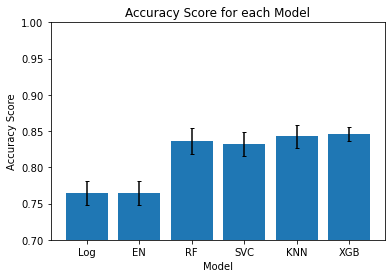

In [36]:
import matplotlib.pyplot as plt

labels = ['Log', 'EN', 'RF', 'SVC', 'KNN', 'XGB']
accuracy = [accuracy_log, accuracy_elastic, accuracy_rf, accuracy_svc, accuracy_knn, accuracy_xgb]

mean_acc = [np.mean(acc) for acc in accuracy]
std_acc = [np.std(acc) for acc in accuracy]

plt.bar(labels, mean_acc, yerr=std_acc, capsize=2)
plt.ylim([0.7,1])
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score for each Model")
plt.savefig('../figures/compare_models_barplot.jpg', dpi=300)
plt.show()

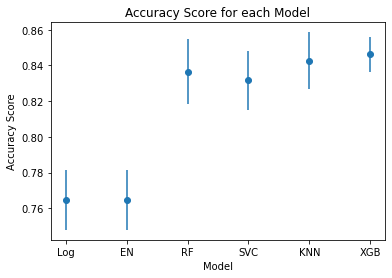

In [38]:
# create the plot
plt.errorbar(range(1,7), mean_acc, yerr = std_acc, fmt='o')
plt.xticks(range(1,7), labels)
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title("Accuracy Score for each Model")
plt.savefig('../figures/compare_models_errorbar.jpg', dpi=300)
plt.show()

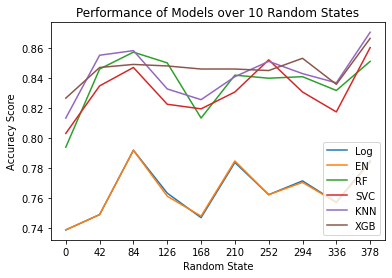

In [39]:
plt.plot(accuracy_log, label=labels[0])
plt.plot(accuracy_elastic, label=labels[1])
plt.plot(accuracy_rf, label=labels[2])
plt.plot(accuracy_svc, label=labels[3])
plt.plot(accuracy_knn, label=labels[4])
plt.plot(accuracy_xgb, label=labels[5])
plt.xticks(range(0,10), [42*i for i in range(10)])
plt.xlabel("Random State")
plt.ylabel("Accuracy Score")
plt.title("Performance of Models over 10 Random States")
plt.legend()
plt.savefig('../figures/compare_model_randomstate.jpg', dpi=300)
plt.show()

In [41]:
print(mean_acc)
print(std_acc)

[0.7648979591836734, 0.7646938775510204, 0.8365306122448981, 0.831734693877551, 0.8426530612244898, 0.8462244897959182]
[0.0168549684815967, 0.01674340241303564, 0.018292363951262502, 0.016532186873857716, 0.01591182492450677, 0.009809195933645088]
